In [85]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn import tree
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

# Classification
When importing dataset, by sorting with MatchID, dataset is now timeseries dataset. Every feature is (home-away) and result is decided with score diff. We have total 50 *STANDARDIZED* feature differences. This data frame is for classification.

In [86]:
data=pd.read_csv('Data/Dataset.csv').drop(['Unnamed: 0'],axis=1).sort_values(by=['MatchID'])
df_home=data.filter(regex='home').rename(columns=lambda x:x.replace('_home',''))
df_away=data.filter(regex='away').rename(columns=lambda x:x.replace('_away',''))
df_diff=df_home-df_away
cond=[(df_diff['Score']<0),(df_diff['Score']==0),(df_diff['Score']>0)]
val=['Away','Draw','Home']
df_diff['Result']=np.select(cond,val)
df_diff=df_diff.drop(columns=['Score'])
X=df_diff.iloc[:,:-1]
y=df_diff.iloc[:,-1:].values.ravel()
test_score={}
val_score={}
score_feature={}

In [87]:
scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)

## Train,Test,Validation set split
Split train,test,validation set into 0.8,0.1,0.1

In [88]:
X_train,X_test,y_train,y_test=train_test_split(X_scaled,y,test_size=0.2)
X_test,X_val,y_test,y_val=train_test_split(X_test,y_test,test_size=0.5)

In [89]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape, X_val.shape, y_val.shape

((2835, 50), (2835,), (354, 50), (354,), (355, 50), (355,))

## SVM

In [90]:
parameters = {'kernel': ('linear', 'rbf'), 'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 'C': np.arange(1, 10)}
svc = svm.SVC()
clf = GridSearchCV(svc, parameters)
clf.fit(X_train, y_train)

GridSearchCV(estimator=SVC(),
             param_grid={'C': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ('linear', 'rbf')})

In [91]:
print(clf.best_params_)
print(clf.best_score_)
test_score['SVM']=clf.score(X_test,y_test)
val_score['SVM']=clf.score(X_val,y_val)
print("test score:"+ str(test_score['SVM']))
print("val score:"+str(val_score['SVM']))

{'C': 8, 'gamma': 0.0001, 'kernel': 'rbf'}
0.5534391534391535
test score:0.5423728813559322
val score:0.5971830985915493


In [92]:
tmp_result=clf.cv_results_
tmp_score=pd.DataFrame(tmp_result['mean_test_score'])
tmp_attr=pd.DataFrame(tmp_result['params'])
fin_score=pd.concat([tmp_score,tmp_attr],axis=1)
fin_score.columns=['Score','C','gamma','kernel']
fin_score=fin_score.sort_values(by='Score',ascending=False)
score_feature['SVM']=fin_score

more refine with fixed kernel

In [93]:
parameters = {'kernel': ['rbf'], 'gamma': [0.001,0.0001,0.00001], 'C': np.arange(1, 10)}
svc = svm.SVC()
clf = GridSearchCV(svc, parameters)
clf.fit(X_train, y_train)

GridSearchCV(estimator=SVC(),
             param_grid={'C': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
                         'gamma': [0.001, 0.0001, 1e-05], 'kernel': ['rbf']})

In [94]:
print(clf.best_params_)
print(clf.best_score_)
print("test score:"+ str(clf.score(X_test,y_test)))
print("val score:"+str(clf.score(X_val,y_val)))

{'C': 8, 'gamma': 0.0001, 'kernel': 'rbf'}
0.5534391534391535
test score:0.5423728813559322
val score:0.5971830985915493


### optimal parameter for SVM classifier
> 'C': 2, 'gamma': 0.001, 'kernel': 'rbf'

test score:0.570
val score:0.569

## SGD classifier

In [95]:
parameters = {'loss':['hinge', 'log_loss', 'modified_huber', 'squared_hinge', 'perceptron', 'squared_error', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'],'max_iter':np.arange(500,5000,step=500)}
svc = SGDClassifier()
clf = GridSearchCV(svc, parameters)
clf.fit(X_train, y_train)

GridSearchCV(estimator=SGDClassifier(),
             param_grid={'loss': ['hinge', 'log_loss', 'modified_huber',
                                  'squared_hinge', 'perceptron',
                                  'squared_error', 'huber',
                                  'epsilon_insensitive',
                                  'squared_epsilon_insensitive'],
                         'max_iter': array([ 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500])})

In [96]:
print(clf.best_params_)
print(clf.best_score_)
test_score['SGD']=clf.score(X_test,y_test)
val_score['SGD']=clf.score(X_val,y_val)
print("test score:"+ str(test_score['SGD']))
print("val score:"+str(val_score['SGD']))

{'loss': 'huber', 'max_iter': 4500}
0.5259259259259259
test score:0.4971751412429379
val score:0.5633802816901409


In [97]:
tmp_result=clf.cv_results_
tmp_score=pd.DataFrame(tmp_result['mean_test_score'])
tmp_attr=pd.DataFrame(tmp_result['params'])
fin_score=pd.concat([tmp_score,tmp_attr],axis=1)
fin_score.columns=['Score','loss','max_iter']
fin_score=fin_score.sort_values(by='Score',ascending=False)
score_feature['SGD']=fin_score

### optimal parameter for SGD classifier
> 'loss': 'log_loss', 'max_iter': 3500

test score:0.542
val score:0.532

## Decision Tree

In [98]:
parameters = {'max_depth':np.arange(1,10)}
TREE = tree.DecisionTreeClassifier()
clf = GridSearchCV(TREE, parameters)
clf.fit(X_train, y_train)

GridSearchCV(estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': array([1, 2, 3, 4, 5, 6, 7, 8, 9])})

In [99]:
print(clf.best_params_)
print(clf.best_score_)
test_score['DT']=clf.score(X_test,y_test)
val_score['DT']=clf.score(X_val,y_val)
print("test score:"+ str(test_score['DT']))
print("val score:"+str(val_score['DT']))

{'max_depth': 2}
0.5298059964726631
test score:0.5310734463276836
val score:0.5690140845070423


In [100]:
tmp_result=clf.cv_results_
tmp_score=pd.DataFrame(tmp_result['mean_test_score'])
tmp_attr=pd.DataFrame(tmp_result['params'])
fin_score=pd.concat([tmp_score,tmp_attr],axis=1)
fin_score.columns=['Score','max_depth']
fin_score=fin_score.sort_values(by='Score',ascending=False)
score_feature['DT']=fin_score

### visualize decision tree

In [101]:
clf=tree.DecisionTreeClassifier(max_depth=3)
clf.fit(X_train,y_train)
from sklearn.tree import export_graphviz
export_graphviz(clf, out_file="tree.dot", class_names = y_train,
                feature_names = X.columns, impurity=True, filled=True)

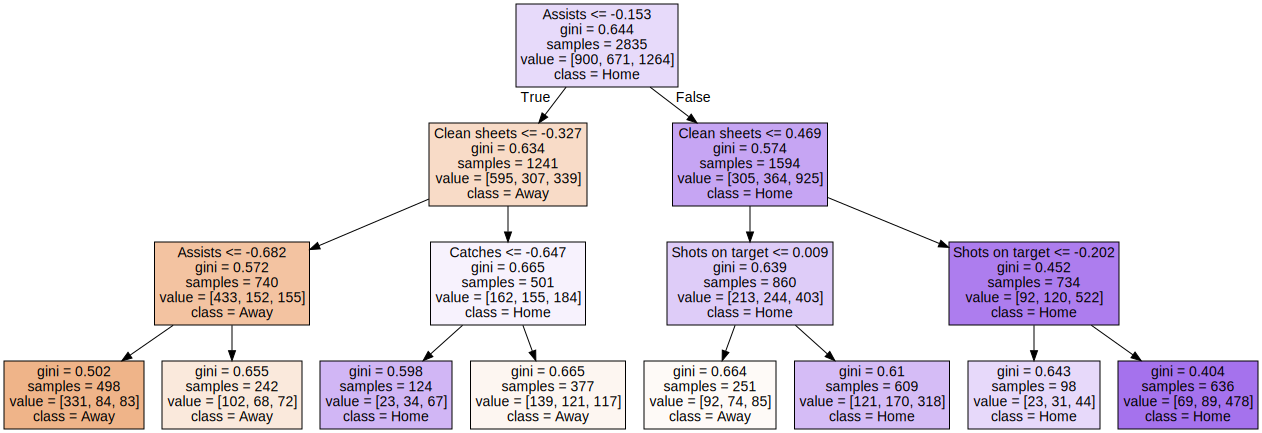

In [102]:
import graphviz
with open("tree.dot") as f:
 dot_graph = f.read()
graphviz.Source(dot_graph)

### optimal parameter for Decision Tree classifier
> max_depth: 3

test score:0.545
val score:0.540

## Random Forest

In [103]:
parameters = {'max_depth':np.arange(1,10)}
RFC = RandomForestClassifier()
clf = GridSearchCV(TREE, parameters)
clf.fit(X_train, y_train)

GridSearchCV(estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': array([1, 2, 3, 4, 5, 6, 7, 8, 9])})

In [104]:
print(clf.best_params_)
print(clf.best_score_)
test_score['RF']=clf.score(X_test,y_test)
val_score['RF']=clf.score(X_val,y_val)
print("test score:"+ str(test_score['RF']))
print("val score:"+str(val_score['RF']))

{'max_depth': 2}
0.5298059964726631
test score:0.5310734463276836
val score:0.5690140845070423


In [105]:
tmp_result=clf.cv_results_
tmp_score=pd.DataFrame(tmp_result['mean_test_score'])
tmp_attr=pd.DataFrame(tmp_result['params'])
fin_score=pd.concat([tmp_score,tmp_attr],axis=1)
fin_score.columns=['Score','max_depth']
fin_score=fin_score.sort_values(by='Score',ascending=False)
score_feature['RF']=fin_score

### optimal parameter for Rnadom Forest classifier
> max_depth: 3

test score:0.545
val score:0.540

# Classfication with feature selection

In [106]:
data=pd.read_csv('Data/Dataset.csv').drop(['Unnamed: 0'],axis=1).sort_values(by=['MatchID'])
df_home=data.filter(regex='home').rename(columns=lambda x:x.replace('_home',''))
df_away=data.filter(regex='away').rename(columns=lambda x:x.replace('_away',''))
df_diff=df_home-df_away
cond=[(df_diff['Score']<0),(df_diff['Score']==0),(df_diff['Score']>0)]
val=['Away','Draw','Home']
df_diff['Result']=np.select(cond,val)
df_diff=df_diff.drop(columns=['Score'])
X=df_diff.iloc[:,:-1]
y=df_diff.iloc[:,-1:].values.ravel()
FS_test_score={}
FS_val_score={}
FS_score_feature={}

## Feature Selection with Tree

Feature ranking:
1. feature Clean sheets (0.041)
2. feature Assists (0.039)
3. feature Big Chances Created (0.032)
4. feature Passes (0.028)
5. feature Blocked shots (0.026)
6. feature Goals (0.026)
7. feature Shots on target (0.025)
8. feature Goals Conceded (0.023)
9. feature Goals with right foot (0.022)
10. feature Big chances missed (0.022)
11. feature Goals with left foot (0.021)
12. feature Hit woodwork (0.021)
13. feature Sweeper clearances (0.020)
14. feature Clearances off line (0.020)
15. feature Tackle success % (0.020)
16. feature Passes per match (0.019)
17. feature Cross accuracy % (0.019)
18. feature Freekicks scored (0.019)
19. feature Crosses (0.019)
20. feature Own goals (0.019)
21. feature Catches (0.019)
22. feature Accurate long balls (0.019)
23. feature Penalties scored (0.018)
24. feature Shots (0.018)
25. feature Punches (0.018)
26. feature Last man tackles (0.018)
27. feature Offsides (0.018)
28. feature Tackles (0.018)
29. feature Errors leading to goal (0.01

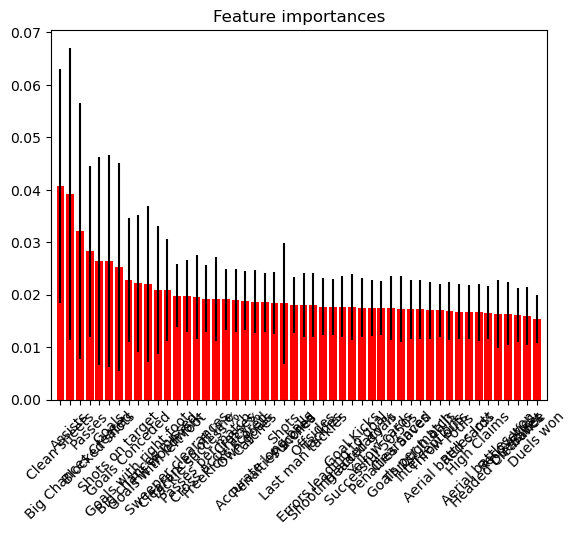

In [107]:
forest=RandomForestClassifier()
forest.fit(X,y)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("{}. feature {} ({:.3f})".format(f + 1, X.columns[indices][f], importances[indices[f]]))

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
        color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), X.columns[indices], rotation=45)
plt.xlim([-1, X.shape[1]])
plt.show()

In [108]:
X=X.drop(columns=X.columns[indices[12:]])

In [109]:
scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)

## Train,Test,Validation set split
Split train,test,validation set into 0.8,0.1,0.1

In [110]:
X_train,X_test,y_train,y_test=train_test_split(X_scaled,y,test_size=0.2)
X_test,X_val,y_test,y_val=train_test_split(X_test,y_test,test_size=0.5)

In [111]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape, X_val.shape, y_val.shape

((2835, 12), (2835,), (354, 12), (354,), (355, 12), (355,))

## SVM

In [112]:
parameters = {'kernel': ('linear', 'rbf'), 'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 'C': np.arange(1, 10)}
svc = svm.SVC()
clf = GridSearchCV(svc, parameters)
clf.fit(X_train, y_train)

GridSearchCV(estimator=SVC(),
             param_grid={'C': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ('linear', 'rbf')})

In [113]:
print(clf.best_params_)
print(clf.best_score_)
FS_test_score['SVM']=clf.score(X_test,y_test)
FS_val_score['SVM']=clf.score(X_val,y_val)
print("test score:"+ str(FS_test_score['SVM']))
print("val score:"+str(FS_val_score['SVM']))

{'C': 3, 'gamma': 0.001, 'kernel': 'rbf'}
0.5513227513227514
test score:0.5649717514124294
val score:0.5746478873239437


In [114]:
tmp_result=clf.cv_results_
tmp_score=pd.DataFrame(tmp_result['mean_test_score'])
tmp_attr=pd.DataFrame(tmp_result['params'])
fin_score=pd.concat([tmp_score,tmp_attr],axis=1)
fin_score.columns=['Score','C','gamma','kernel']
fin_score=fin_score.sort_values(by='Score',ascending=False)
FS_score_feature['SVM']=fin_score

more refine with fixed kernel

In [115]:
parameters = {'kernel': ['rbf'], 'gamma': [0.001,0.0001,0.00001], 'C': np.arange(1, 10)}
svc = svm.SVC()
clf = GridSearchCV(svc, parameters)
clf.fit(X_train, y_train)

GridSearchCV(estimator=SVC(),
             param_grid={'C': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
                         'gamma': [0.001, 0.0001, 1e-05], 'kernel': ['rbf']})

In [116]:
print(clf.best_params_)
print(clf.best_score_)
print("test score:"+ str(clf.score(X_test,y_test)))
print("val score:"+str(clf.score(X_val,y_val)))

{'C': 3, 'gamma': 0.001, 'kernel': 'rbf'}
0.5513227513227514
test score:0.5649717514124294
val score:0.5746478873239437


### optimal parameter for SVM classifier
> 'C': 2, 'gamma': 0.001, 'kernel': 'rbf'

test score:0.570
val score:0.569

## SGD classifier

In [117]:
parameters = {'loss':['hinge', 'log_loss', 'modified_huber', 'squared_hinge', 'perceptron', 'squared_error', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'],'max_iter':np.arange(500,5000,step=500)}
svc = SGDClassifier()
clf = GridSearchCV(svc, parameters)
clf.fit(X_train, y_train)

GridSearchCV(estimator=SGDClassifier(),
             param_grid={'loss': ['hinge', 'log_loss', 'modified_huber',
                                  'squared_hinge', 'perceptron',
                                  'squared_error', 'huber',
                                  'epsilon_insensitive',
                                  'squared_epsilon_insensitive'],
                         'max_iter': array([ 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500])})

In [118]:
print(clf.best_params_)
print(clf.best_score_)
FS_test_score['SGD']=clf.score(X_test,y_test)
FS_val_score['SGD']=clf.score(X_val,y_val)
print("test score:"+ str(FS_test_score['SGD']))
print("val score:"+str(FS_val_score['SGD']))

{'loss': 'log_loss', 'max_iter': 1000}
0.5488536155202821
test score:0.5310734463276836
val score:0.532394366197183


In [119]:
tmp_result=clf.cv_results_
tmp_score=pd.DataFrame(tmp_result['mean_test_score'])
tmp_attr=pd.DataFrame(tmp_result['params'])
fin_score=pd.concat([tmp_score,tmp_attr],axis=1)
fin_score.columns=['Score','loss','max_iter']
fin_score=fin_score.sort_values(by='Score',ascending=False)
FS_score_feature['SGD']=fin_score

### optimal parameter for SGD classifier
> 'loss': 'log_loss', 'max_iter': 3500

test score:0.542
val score:0.532

## Decision Tree

In [120]:
parameters = {'max_depth':np.arange(1,10)}
TREE = tree.DecisionTreeClassifier()
clf = GridSearchCV(TREE, parameters)
clf.fit(X_train, y_train)

GridSearchCV(estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': array([1, 2, 3, 4, 5, 6, 7, 8, 9])})

In [121]:
print(clf.best_params_)
print(clf.best_score_)
FS_test_score['DT']=clf.score(X_test,y_test)
FS_val_score['DT']=clf.score(X_val,y_val)
print("test score:"+ str(FS_test_score['DT']))
print("val score:"+str(FS_val_score['DT']))

{'max_depth': 3}
0.5305114638447972
test score:0.53954802259887
val score:0.532394366197183


In [122]:
tmp_result=clf.cv_results_
tmp_score=pd.DataFrame(tmp_result['mean_test_score'])
tmp_attr=pd.DataFrame(tmp_result['params'])
fin_score=pd.concat([tmp_score,tmp_attr],axis=1)
fin_score.columns=['Score','max_depth']
fin_score=fin_score.sort_values(by='Score',ascending=False)
FS_score_feature['DT']=fin_score

### visualize decision tree

In [123]:
clf=tree.DecisionTreeClassifier(max_depth=3)
clf.fit(X_train,y_train)
from sklearn.tree import export_graphviz
export_graphviz(clf, out_file="FS_tree.dot", class_names = y_train,
                feature_names = X.columns, impurity=True, filled=True)

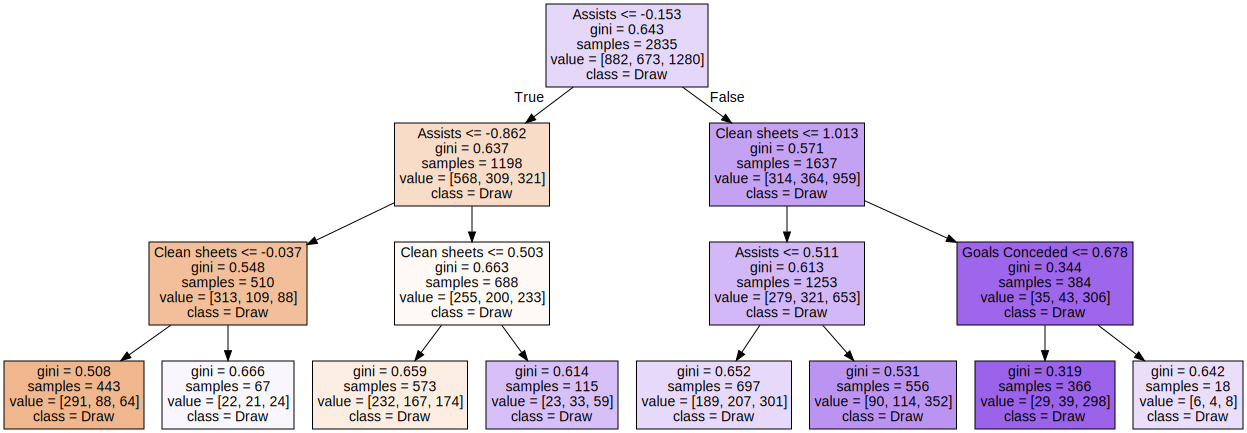

In [124]:
import graphviz
with open("FS_tree.dot") as f:
 dot_graph = f.read()
graphviz.Source(dot_graph)

### optimal parameter for Decision Tree classifier
> max_depth: 3

test score:0.545
val score:0.540

## Random Forest

In [125]:
parameters = {'max_depth':np.arange(1,10)}
RFC = RandomForestClassifier()
clf = GridSearchCV(TREE, parameters)
clf.fit(X_train, y_train)

GridSearchCV(estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': array([1, 2, 3, 4, 5, 6, 7, 8, 9])})

In [126]:
print(clf.best_params_)
print(clf.best_score_)
FS_test_score['RF']=clf.score(X_test,y_test)
FS_val_score['RF']=clf.score(X_val,y_val)
print("test score:"+ str(FS_test_score['RF']))
print("val score:"+str(FS_val_score['RF']))

{'max_depth': 3}
0.5305114638447972
test score:0.53954802259887
val score:0.532394366197183


In [127]:
tmp_result=clf.cv_results_
tmp_score=pd.DataFrame(tmp_result['mean_test_score'])
tmp_attr=pd.DataFrame(tmp_result['params'])
fin_score=pd.concat([tmp_score,tmp_attr],axis=1)
fin_score.columns=['Score','max_depth']
fin_score=fin_score.sort_values(by='Score',ascending=False)
FS_score_feature['RF']=fin_score

### optimal parameter for Rnadom Forest classifier
> max_depth: 3

test score:0.545
val score:0.540

In [130]:
val_score

{'SVM': 0.5971830985915493,
 'SGD': 0.5633802816901409,
 'DT': 0.5690140845070423,
 'RF': 0.5690140845070423}

In [131]:
FS_val_score

{'SVM': 0.5746478873239437,
 'SGD': 0.532394366197183,
 'DT': 0.532394366197183,
 'RF': 0.532394366197183}